# OGGM - data pulling

## Setting up:

In [15]:
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import pyproj
from pyproj import Transformer
import salem
from tqdm.notebook import tqdm
import logging
import matplotlib.pyplot as plt
from oggm import cfg, utils, workflow, tasks

cfg.initialize(logging_level='WARNING')
cfg.PARAMS['border'] = 10
cfg.PARAMS['use_multiprocessing'] = True
cfg.PARAMS['continue_on_error'] = True
# Module logger
log = logging.getLogger('.'.join(__name__.split('.')[:-1]))

2024-10-24 09:27:39: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-10-24 09:27:39: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-10-24 09:27:39: oggm.cfg: Multiprocessing: using all available processors (N=32)
2024-10-24 09:27:39: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2024-10-24 09:27:39: oggm.cfg: Multiprocessing switched ON after user settings.
2024-10-24 09:27:39: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.


## Download OGGM data:

In [16]:
# set working directory
working_dir = '../../../data/OGGM/'
cfg.PATHS['working_dir'] = working_dir

# Set RGI version and region:
rgi_region = "11"  # Central Europe
rgi_version = "6"
rgi_dir = utils.get_rgi_dir(version=rgi_version)

In [17]:
path = utils.get_rgi_region_file(region=rgi_region, version=rgi_version)
rgidf = gpd.read_file(path)

# We use the directories with the shop data in it: "W5E5_w_data"
base_url = "https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.1/elev_bands/W5E5_w_data/"
gdirs = workflow.init_glacier_directories(
    rgidf,
    from_prepro_level=3,
    prepro_base_url=base_url,
    prepro_border=10,
    reset=True,
    force=True,
)

2024-10-24 09:27:41: oggm.workflow: init_glacier_directories from prepro level 3 on 3927 glaciers.
2024-10-24 09:27:41: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 3927 glaciers


In [18]:
# Tested tasks
task_list = [
    tasks.gridded_attributes,
    # tasks.gridded_mb_attributes,
    # get_gridded_features,
]
for task in task_list:
    workflow.execute_entity_task(task, gdirs, print_log=False)

2024-10-24 09:28:07: oggm.workflow: Execute entity tasks [gridded_attributes] on 3927 glaciers


## Load PMB data:

,YEAR,POINT_ID,GLACIER,FROM_DATE,TO_DATE,POINT_LAT,POINT_LON,POINT_ELEVATION,POINT_BALANCE,PERIOD,RGIId
0,2006,100,adler,20051017,20061011,46.010637,7.855896,3096.507742,-2.592,annual,RGI60-11.02764
1,2006,200,adler,20051017,20061011,46.010052,7.858628,3141.506520,-2.502,annual,RGI60-11.02764
2,2006,300,adler,20051017,20061011,46.010646,7.860957,3191.502735,-2.592,annual,RGI60-11.02764


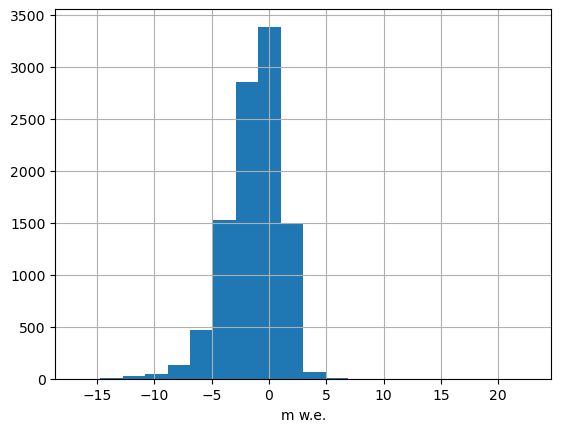

In [19]:
DF_TYPE = 'close' # 'all' or 'close' depending on whether we also want snow probes

# Load PMB data:
path_PMB_GLAMOS_csv = '../../../data/GLAMOS/point/csv/'
df_pmb = pd.read_csv(path_PMB_GLAMOS_csv + f'df_pmb_50s_clean_{DF_TYPE}.csv')
# Histogram of mass balance
df_pmb['POINT_BALANCE'].hist(bins=20)
plt.xlabel('m w.e.')
df_pmb.head(3)

In [20]:
# Get info of that sample:
i = 0
RGI = df_pmb.iloc[i].RGIId
POINT_LAT, POINT_LON = df_pmb.iloc[i].POINT_LAT, df_pmb.iloc[i].POINT_LON

# Get oggm data for that RGI ID
for gdir in gdirs:
    if gdir.rgi_id == RGI:
        break
# gdir = find_gdir(gdirs, RGI)

with xr.open_dataset(gdir.get_filepath("gridded_data")) as ds:
    ds = ds.load()
ds

<xarray.Dataset>
Dimensions:                  (x: 133, y: 68)
Coordinates:
  * x                        (x) float32 -2.077e+03 -2.047e+03 ... 1.883e+03
  * y                        (y) float32 5.097e+06 5.097e+06 ... 5.095e+06
Data variables: (12/17)
    topo                     (y, x) float32 2.989e+03 2.996e+03 ... 3.613e+03
    topo_smoothed            (y, x) float32 3.007e+03 3.009e+03 ... 3.63e+03
    topo_valid_mask          (y, x) int8 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    glacier_mask             (y, x) int8 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    glacier_ext              (y, x) int8 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    consensus_ice_thickness  (y, x) float32 nan nan nan nan ... nan nan nan nan
    ...                       ...
    glacier_ext_erosion      (y, x) int8 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    ice_divides              (y, x) int8 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    slope                    (y, x) float32 0.1747 0.1881 ... 0.3885 0.3636
    aspect                   (y, x) float32 5.814 5.666 5.472 ... 3.591 3.477
    slope_factor             (y, x) float32 2.849 2.725 2.51 ... 1.764 1.835
    dis_from_border          (y, x) float32 1.262e+03 1.253e+03 ... 834.1 852.8
Attributes:
    author:         OGGM
    author_info:    Open Global Glacier Model
    pyproj_srs:     +proj=tmerc +lat_0=0 +lon_0=7.87661 +k=0.9996 +x_0=0 +y_0...
    max_h_dem:      4145.0
    min_h_dem:      2858.0
    max_h_glacier:  4100.0
    min_h_glacier:  2976.0

## Merge with OGGM data:

In [21]:
# variables of interest from oggm
voi = [
    "aspect", "slope", "dis_from_border", "topo", "hugonnet_dhdt",
    "consensus_ice_thickness", "millan_ice_thickness", "millan_v", "millan_vx",
    "millan_vy"
]

# Initialise empty:
for var in voi:
    df_pmb[var] = np.nan

for i in tqdm(range(len(df_pmb)), desc='rows'):
    # Get info of that sample:
    RGI = df_pmb.iloc[i].RGIId
    POINT_LAT, POINT_LON = df_pmb.iloc[i].POINT_LAT, df_pmb.iloc[i].POINT_LON

    # Get oggm data for that RGI ID
    for gdir in gdirs:
        if gdir.rgi_id == RGI:
            break
    # gdir = find_gdir(gdirs, RGI)

    with xr.open_dataset(gdir.get_filepath("gridded_data")) as ds:
        ds = ds.load()

    # Transform stake coord to glacier system:
    transf = pyproj.Transformer.from_proj(salem.wgs84,
                                          gdir.grid.proj,
                                          always_xy=True)
    x_stake, y_stake = transf.transform(POINT_LON, POINT_LAT)  # x,y stake

    # Get glacier variables closest to these coordinates:
    stake = ds.sel(x=x_stake, y=y_stake, method="nearest")

    # Calculate min, max and median topography of glacier:
    # min_glacier = ds.where(ds.glacier_mask == 1).topo.min().values
    # max_glacier = ds.where(ds.glacier_mask == 1).topo.max().values
    # med_glacier = ds.where(ds.glacier_mask == 1).topo.median().values

    # Select variables of interest:
    stake_var = stake[voi]
    stake_var_df = stake_var.to_pandas()

    for var in stake_var_df.index:
        df_pmb.at[i, var] = stake_var_df.loc[var]

df_pmb.head()


rows:   0%|          | 0/10006 [00:00<?, ?it/s]

,YEAR,POINT_ID,GLACIER,FROM_DATE,TO_DATE,POINT_LAT,POINT_LON,POINT_ELEVATION,POINT_BALANCE,PERIOD,...,aspect,slope,dis_from_border,topo,hugonnet_dhdt,consensus_ice_thickness,millan_ice_thickness,millan_v,millan_vx,millan_vy
0,2006,100,adler,20051017,20061011,46.010637,7.855896,3096.507742,-2.592,annual,...,4.441578,0.340053,120.000000,3039.0,-1.504815,43.181839,37.110600,3.591626,3.445628,1.013618
1,2006,200,adler,20051017,20061011,46.010052,7.858628,3141.506520,-2.502,annual,...,4.772892,0.219036,30.000000,3091.0,-0.970061,41.090096,8.961324,0.975349,-0.948907,-0.058481
2,2006,300,adler,20051017,20061011,46.010646,7.860957,3191.502735,-2.592,annual,...,4.480725,0.306125,150.000000,3143.0,-1.284834,61.502941,29.594700,0.503317,-0.221818,-0.279207
3,2007,100,adler,20061011,20071009,46.010602,7.855728,3093.507997,-2.250,annual,...,4.399832,0.355558,108.166542,3026.0,-1.452664,39.826572,37.936680,3.881994,3.839135,0.575254
4,2007,200,adler,20061011,20071009,46.010169,7.858461,3124.506390,-1.836,annual,...,4.717781,0.213309,60.000000,3084.0,-1.188978,49.265205,16.608761,1.298901,-1.202490,0.491084


In [22]:
# Save to csv:
df_pmb.to_csv(path_PMB_GLAMOS_csv + f'CH_wgms_dataset_{DF_TYPE}.csv', index=False)
df_pmb.head(3)

,YEAR,POINT_ID,GLACIER,FROM_DATE,TO_DATE,POINT_LAT,POINT_LON,POINT_ELEVATION,POINT_BALANCE,PERIOD,...,aspect,slope,dis_from_border,topo,hugonnet_dhdt,consensus_ice_thickness,millan_ice_thickness,millan_v,millan_vx,millan_vy
0,2006,100,adler,20051017,20061011,46.010637,7.855896,3096.507742,-2.592,annual,...,4.441578,0.340053,120.0,3039.0,-1.504815,43.181839,37.110600,3.591626,3.445628,1.013618
1,2006,200,adler,20051017,20061011,46.010052,7.858628,3141.506520,-2.502,annual,...,4.772892,0.219036,30.0,3091.0,-0.970061,41.090096,8.961324,0.975349,-0.948907,-0.058481
2,2006,300,adler,20051017,20061011,46.010646,7.860957,3191.502735,-2.592,annual,...,4.480725,0.306125,150.0,3143.0,-1.284834,61.502941,29.594700,0.503317,-0.221818,-0.279207


## Add avalanche data:

In [23]:
# set working directory
working_dir = '../../../data/OGGM/'
cfg.PATHS['working_dir'] = working_dir

# Set RGI version and region:
rgi_region = "11"  # Central Europe
rgi_version = "6"
rgi_dir = utils.get_rgi_dir(version=rgi_version)

path = utils.get_rgi_region_file(region=rgi_region, version=rgi_version)
rgidf = gpd.read_file(path)

# We use the directories with the shop data in it: "W5E5_w_data"
base_url = 'https://cluster.klima.uni-bremen.de/~mkneib/global_whypso/'
gdirs = workflow.init_glacier_directories(
    rgidf,
    prepro_base_url=base_url,
    from_prepro_level=3,
    prepro_border=80,
    reset=True,
    force=True,
)

2024-10-24 09:30:23: oggm.workflow: init_glacier_directories from prepro level 3 on 3927 glaciers.
2024-10-24 09:30:24: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 3927 glaciers


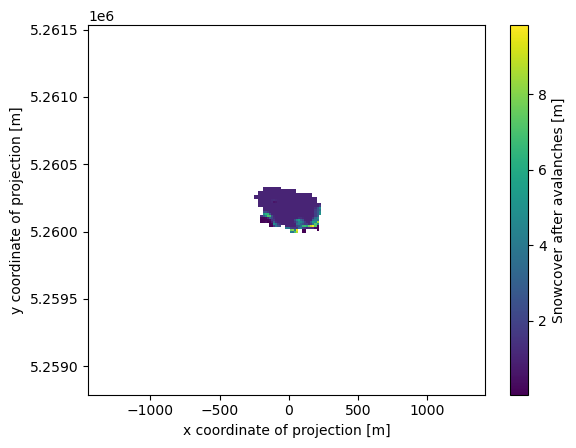

In [24]:
gdir = gdirs[0]
# Get the path to the gridded data file & open it
with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
    ds = ds.load()
ds.snowslide_1m.where(ds.glacier_mask).plot()
plt.show()

In [25]:
# Save to csv:
DF_TYPE = 'close' # 'all' or 'close' depending on whether we also want snow probes

# Load PMB data:
path_PMB_GLAMOS_csv = '../../../data/GLAMOS/point/csv/'

df_pmb = pd.read_csv(path_PMB_GLAMOS_csv + f'CH_wgms_dataset_{DF_TYPE}.csv')
df_pmb.head(3)

,YEAR,POINT_ID,GLACIER,FROM_DATE,TO_DATE,POINT_LAT,POINT_LON,POINT_ELEVATION,POINT_BALANCE,PERIOD,...,aspect,slope,dis_from_border,topo,hugonnet_dhdt,consensus_ice_thickness,millan_ice_thickness,millan_v,millan_vx,millan_vy
0,2006,100,adler,20051017,20061011,46.010637,7.855896,3096.507742,-2.592,annual,...,4.441578,0.340053,120.0,3039.0,-1.504815,43.181839,37.110600,3.591626,3.445628,1.013618
1,2006,200,adler,20051017,20061011,46.010052,7.858628,3141.506520,-2.502,annual,...,4.772892,0.219036,30.0,3091.0,-0.970061,41.090096,8.961324,0.975349,-0.948907,-0.058481
2,2006,300,adler,20051017,20061011,46.010646,7.860957,3191.502735,-2.592,annual,...,4.480725,0.306125,150.0,3143.0,-1.284834,61.502941,29.594700,0.503317,-0.221818,-0.279207


In [26]:
# variables of interest from oggm
voi = ["snowslide_1m"]

# Initialise empty:
for var in voi:
    df_pmb[var] = np.nan

for i in tqdm(range(len(df_pmb)), desc='rows'):
    # Get info of that sample:
    RGI = df_pmb.iloc[i].RGIId
    POINT_LAT, POINT_LON = df_pmb.iloc[i].POINT_LAT, df_pmb.iloc[i].POINT_LON

    # Get oggm data for that RGI ID
    for gdir in gdirs:
        if gdir.rgi_id == RGI:
            break
    # gdir = find_gdir(gdirs, RGI)

    with xr.open_dataset(gdir.get_filepath("gridded_data")) as ds:
        ds = ds.load()

    # Transform stake coord to glacier system:
    transf = pyproj.Transformer.from_proj(salem.wgs84,
                                          gdir.grid.proj,
                                          always_xy=True)
    x_stake, y_stake = transf.transform(POINT_LON, POINT_LAT)  # x,y stake

    # Get glacier variables closest to these coordinates:
    stake = ds.sel(x=x_stake, y=y_stake, method="nearest")

    # Select variables of interest:
    stake_var = stake[voi]
    stake_var_df = stake_var.to_pandas()

    for var in stake_var_df.index:
        df_pmb.at[i, var] = stake_var_df.loc[var]

df_pmb.head()

rows:   0%|          | 0/10006 [00:00<?, ?it/s]

,YEAR,POINT_ID,GLACIER,FROM_DATE,TO_DATE,POINT_LAT,POINT_LON,POINT_ELEVATION,POINT_BALANCE,PERIOD,...,slope,dis_from_border,topo,hugonnet_dhdt,consensus_ice_thickness,millan_ice_thickness,millan_v,millan_vx,millan_vy,snowslide_1m
0,2006,100,adler,20051017,20061011,46.010637,7.855896,3096.507742,-2.592,annual,...,0.340053,120.000000,3039.0,-1.504815,43.181839,37.110600,3.591626,3.445628,1.013618,1.0
1,2006,200,adler,20051017,20061011,46.010052,7.858628,3141.506520,-2.502,annual,...,0.219036,30.000000,3091.0,-0.970061,41.090096,8.961324,0.975349,-0.948907,-0.058481,1.0
2,2006,300,adler,20051017,20061011,46.010646,7.860957,3191.502735,-2.592,annual,...,0.306125,150.000000,3143.0,-1.284834,61.502941,29.594700,0.503317,-0.221818,-0.279207,1.0
3,2007,100,adler,20061011,20071009,46.010602,7.855728,3093.507997,-2.250,annual,...,0.355558,108.166542,3026.0,-1.452664,39.826572,37.936680,3.881994,3.839135,0.575254,1.0
4,2007,200,adler,20061011,20071009,46.010169,7.858461,3124.506390,-1.836,annual,...,0.213309,60.000000,3084.0,-1.188978,49.265205,16.608761,1.298901,-1.202490,0.491084,1.0


In [27]:
# Save to csv:
df_pmb.to_csv(path_PMB_GLAMOS_csv + f'CH_wgms_dataset_{DF_TYPE}.csv', index=False)

<Axes: >

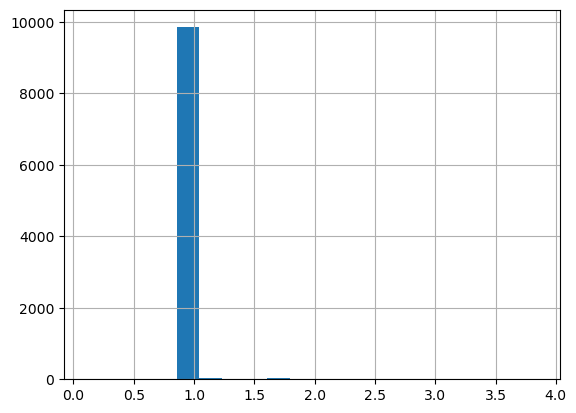

In [28]:
# Plot distribution of snowslide_1m:
df_pmb['snowslide_1m'].hist(bins=20)

In [29]:
# Find glaciers with snowslide_1m > 1:
df_pmb[df_pmb['snowslide_1m'] > 1]

,YEAR,POINT_ID,GLACIER,FROM_DATE,TO_DATE,POINT_LAT,POINT_LON,POINT_ELEVATION,POINT_BALANCE,PERIOD,...,slope,dis_from_border,topo,hugonnet_dhdt,consensus_ice_thickness,millan_ice_thickness,millan_v,millan_vx,millan_vy,snowslide_1m
64,1956,Q1,albigna,19551014,19561010,46.320194,9.645952,2262.941876,-1.485,annual,...,0.245523,336.535278,2156.0,0.000382,NaN,NaN,0.000000,0.000000,0.000000,3.848444
70,1956,Q1,albigna,19551001,19560427,46.320194,9.645952,2267.941876,0.463,winter,...,0.245523,336.535278,2156.0,0.000382,NaN,NaN,0.000000,0.000000,0.000000,3.848444
87,1958,Q1,albigna,19571010,19581009,46.320268,9.645987,2255.941657,-2.043,annual,...,0.245523,336.535278,2156.0,0.000382,NaN,NaN,0.000000,0.000000,0.000000,3.848444
93,1958,Q1,albigna,19571001,19580501,46.320268,9.645987,2267.941657,0.746,winter,...,0.245523,336.535278,2156.0,0.000382,NaN,NaN,0.000000,0.000000,0.000000,3.848444
96,1959,Q1,albigna,19581009,19591007,46.320290,9.645999,2252.941590,-1.836,annual,...,0.245523,336.535278,2156.0,0.000382,NaN,NaN,0.000000,0.000000,0.000000,3.848444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8060,2016,s4,schwarzbach,20151001,20160415,46.596488,8.612146,2787.294227,1.502,winter,...,0.418072,29.068884,2741.0,-0.519960,13.335523,1.840047,0.254818,-0.179925,0.154161,1.076503
8062,2017,116,schwarzbach,20161003,20170924,46.596462,8.612067,2774.294371,-2.385,annual,...,0.451742,26.000000,2747.0,-0.488163,12.629236,2.363897,0.110042,-0.073998,0.081446,2.944863
8064,2017,s5,schwarzbach,20161001,20170422,46.596534,8.612121,2761.294139,1.643,winter,...,0.418072,29.068884,2741.0,-0.519960,13.335523,1.840047,0.254818,-0.179925,0.154161,1.076503
8066,2018,117,schwarzbach,20170924,20180920,46.596444,8.612079,2794.294404,-2.961,annual,...,0.462198,18.384777,2746.0,-0.473891,12.392306,0.809612,0.037688,-0.025343,0.027894,2.736410


rows:   0%|          | 0/38 [00:00<?, ?it/s]

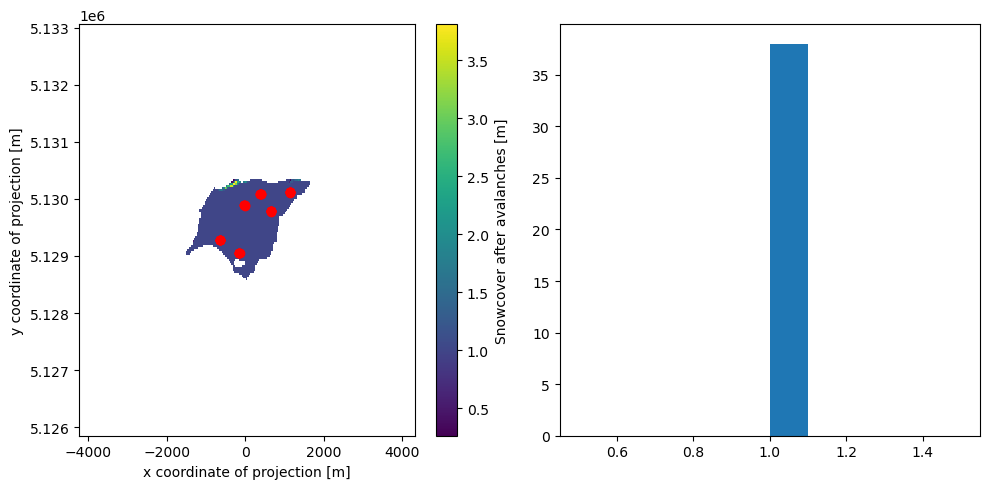

In [30]:
df_pmb_subset = df_pmb[(df_pmb.GLACIER == 'tsanfleuron')&(df_pmb.YEAR > 2010)]
x_stakes, y_stakes, snowslide_1m_ = [], [], []
for i in tqdm(range(len((df_pmb_subset))), desc='rows'):
    # Get info of that sample:
    RGI = df_pmb_subset.iloc[i].RGIId
    POINT_LAT, POINT_LON = df_pmb_subset.iloc[i].POINT_LAT, df_pmb_subset.iloc[i].POINT_LON

    # Get oggm data for that RGI ID
    for gdir in gdirs:
        if gdir.rgi_id == RGI:
            break
    # gdir = find_gdir(gdirs, RGI)

    with xr.open_dataset(gdir.get_filepath("gridded_data")) as ds:
        ds = ds.load()

    # Transform stake coord to glacier system:
    transf = pyproj.Transformer.from_proj(salem.wgs84,
                                          gdir.grid.proj,
                                          always_xy=True)
    x_stake, y_stake = transf.transform(POINT_LON, POINT_LAT)  # x,y stake

    # Get glacier variables closest to these coordinates:
    stake = ds.sel(x=x_stake, y=y_stake, method="nearest")
    
    x_stakes.append(x_stake)
    y_stakes.append(y_stake)
    snowslide_1m_.append(stake.snowslide_1m.values)
   
fig = plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1) 
ds.snowslide_1m.where(ds.glacier_mask).plot()
# plot stake
for x_stake, y_stake in zip(x_stakes, y_stakes):
    plt.scatter(x_stake, y_stake, color='r')
    
# plot distribution of snowslide_1m
plt.subplot(1, 2, 2)
plt.hist(snowslide_1m_)
plt.tight_layout()